Trying a new approach using feature engineering

In [260]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv("issue_data_sna.csv")

#add a column for issue lifetime hourse
df['Issue Lifetime (hours)'] = None

In [261]:
#drop row if pr merge date is null
df= df.dropna(subset=['PR Merge Date'])

In [262]:
#calculkating difference in time between PR merge date and open date
df['Open Date'] = pd.to_datetime(df['Open Date'], format='%Y-%m-%dT%H:%M:%SZ')
df['PR Merge Date'] = pd.to_datetime(df['PR Merge Date'], format='%Y-%m-%dT%H:%M:%SZ')
df['Closed Date'] = pd.to_datetime(df['Closed Date'], format='%Y-%m-%dT%H:%M:%SZ')
df['Issue Lifetime (hours)'] = (df['PR Merge Date'] - df['Open Date']).dt.total_seconds() / 3600
# Round the 'Issue Lifetime (hours)' to the nearest whole number
#df['Issue Lifetime (hours)-whole'] = df['Issue Lifetime (hours)'].round()


In [263]:
# Define the conditions for the 'Issue Lifetime' groups
conditions = [
    (df['Issue Lifetime (hours)'] < 48),  # less than 2 days - group 1
    (df['Issue Lifetime (hours)'] >= 48) & (df['Issue Lifetime (hours)'] < 168),  # between 2 days and a week - group 2
    (df['Issue Lifetime (hours)'] >= 168) & (df['Issue Lifetime (hours)'] < 720),  # between a week and a month - group 3
    (df['Issue Lifetime (hours)'] >= 720)  # more than a month - group 4
]

# Define the corresponding group numbers
groups = [1, 2, 3, 4]
group_dict={
    1: 'Less than 2 days',
    2: 'Between 2 days and a week',
    3: 'Between a week and a month',
    4: 'More than a month'
}

# Create the 'Issue Lifetime' column using np.select
df['Issue Lifetime'] = np.select(conditions, groups)



In [264]:
# Define the mapping
mapping = {
    1: '<2 days',
    2: '2 days - 1 week',
    3: '1 week - 1 month',
    4: '>1 month'
}

# Map the 'Issue Lifetime' values to the new column headings
df['Issue Lifetime'] = df['Issue Lifetime'].map(mapping)

# Perform one-hot encoding
one_hot_encoded_df = pd.get_dummies(df['Issue Lifetime'])
one_hot_encoded_df = one_hot_encoded_df.astype(int)

# Combine with the original DataFrame
#df = pd.concat([df, one_hot_encoded_df], axis=1)



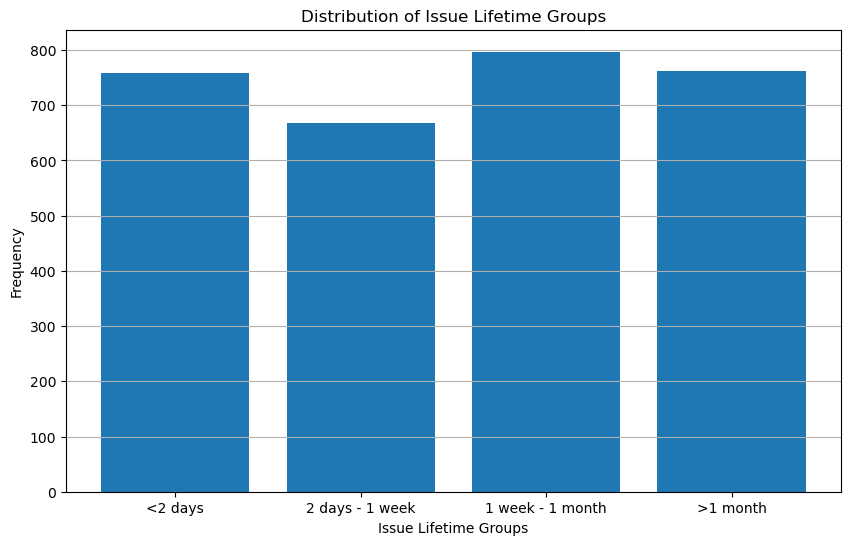

In [265]:
# Graphing the distribution of the groups
group_counts = df['Issue Lifetime'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values, tick_label=['<2 days', '2 days - 1 week', '1 week - 1 month', '>1 month'])
plt.title('Distribution of Issue Lifetime Groups')
plt.xlabel('Issue Lifetime Groups')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()


In [266]:
#Split the comment authors into a list 
df['Comment Authors List'] = df['Comment Authors'].str.split('|')
if df['Comment Authors List'].isnull().values.any():
    df['Comment Authors List'] = df['Comment Authors List'].fillna('')

In [267]:
def clean_authors_list(authors_list):
    # If the list is empty or NaN, return an empty list
    if not authors_list:
        return []
    cleaned_list = [author for author in authors_list if author != 'SEPARATOR']
    return cleaned_list

df['Comment Authors List'] = df['Comment Authors List'].apply(clean_authors_list)


In [268]:
from collections import Counter
# Initialize the new column
df['Unique Comment Authors'] = 0
df['Author Comments']= 0
for i in range(0, len(df)):
    authors_list = df['Comment Authors List'][i]
    if authors_list:
        author_dict = Counter(authors_list)
        
        if df['author'][i] in author_dict:
            #find out hbow many tiems the author commented
            df.loc[i, 'Author Comments'] = author_dict[df['author'].iloc[i]]            
            #remove the author from the dictionary
            del author_dict[df['author'][i]]
        
        df.loc[i, 'Unique Comment Authors'] = (len(author_dict))



In [269]:
# Function to remove specific prefixes from labels
def remove_prefixes(labels):
    if pd.isna(labels):
        return labels
    prefixes = ['type:', 'scope:', 'platform:', 'status:', 'other:']
    for prefix in prefixes:
        labels = labels.replace(prefix, '')
    return labels

# Apply the function to the 'Labels' column
df['Labels'] = df['Labels'].apply(remove_prefixes)

# drop comment auhtor list
df.drop(columns=['Comment Authors List'], inplace=True)

# drop Pull request number
df.drop(columns=['PR Number'], inplace=True)




In [270]:
# make a list of all the unique labels
unique_labels = df['Labels'].str.split(',').explode().str.strip().unique()

#delete nan
unique_labels = [x for x in unique_labels if str(x) != 'nan']

# add a column for each unique label
for item in unique_labels:
    if isinstance(item, str) and item:
        df[item] = df['Labels'].apply(lambda x: 1 if isinstance(x, str) and item in x else 0)

# add a column that counts the number of labels
df['Number of Labels'] = df['Labels'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)

# droping the lables column
df.drop(columns=['Labels'], inplace=True)

In [271]:
# delete '|SEPARATOR|' from comment bodies
df['Comment Bodies'] = df['Comment Bodies'].str.replace('|SEPARATOR|', ' ')

#find the total number of words in Issue Body
df['Issue wordiness'] = df['Issue Body'].str.split().str.len()

# divide the comment word count by number fo comments to get wordiness
df['Comment Wordiness'] = df['Comment Bodies'].str.split().str.len() / df['Number of Comments']

# Issue title length in characters
df['Title Length'] = df['Issue Title'].str.len()


In [272]:
# fro each row calcualte how many Issue have been opened since 2 weeks before teh current issue was opened
df['Issues Opened in Last 2 Weeks'] = 0
for i in range(0, len(df)):
    open_date = df['Open Date'][i]
    two_weeks_before = open_date - pd.Timedelta(days=14)
    issues_opened = df[(df['Open Date'] >= two_weeks_before) & (df['Open Date'] < open_date)].shape[0]
    df.loc[i, 'Issues Opened in Last 2 Weeks'] = issues_opened
    
# fro each row calcualte how many Issue have been closed since 2 weeks before teh current issue was opened
df['Issues Closed in Last 2 Weeks'] = 0
for i in range(0, len(df)):
    closed_date = df['Closed Date'][i]
    two_weeks_before = closed_date - pd.Timedelta(days=14)
    issues_closed = df[(df['Closed Date'] >= two_weeks_before) & (df['Closed Date'] < closed_date)].shape[0]
    df.loc[i, 'Issues Closed in Last 2 Weeks'] = issues_closed


# for each row calcualte the nubmer of open pull requests at the time the issue was opened i.e pr merge date is after the open date
df['Open PRs at Open Date'] = 0
for i in range(len(df)):
    open_date = df.loc[i, 'Open Date']
    open_prs = df[(df['Open Date'] < open_date) & (df['PR Merge Date'] > open_date)].shape[0]
    df.loc[i, 'Open PRs at Open Date'] = open_prs


In [273]:
#for each row calcualte how many pull requests were opened before by the author
df['Author PRs Opened'] = 0
for i in range(len(df)):
    author = df.loc[i, 'author']
    author_prs = df[(df['author'] == author) & (df['Open Date'] < df['Open Date'][i])].shape[0]
    df.loc[i, 'Author PRs Opened'] = author_prs
    
#columns to drop
df.drop(columns=[])

In [274]:
from sklearn.model_selection import train_test_split

#do a trian test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)



In [275]:
import seaborn as sns

def feature_corr(data):
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    
feature_corr(train_df)

ValueError: could not convert string to float: 'repository0'